# Implémentez un modèle de scoring

In [1]:
# !pip install pycaret

In [2]:
# !pip install bokeh

In [3]:
#! pip install xgboost

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
import xgboost as xgb


In [5]:
appTest = pd.read_csv("zip/application_test.csv")
appTrain = pd.read_csv("zip/application_train.csv")
bureau = pd.read_csv("zip/bureau.csv")
bureauBal = pd.read_csv("zip/bureau_balance.csv")
creditCardBal = pd.read_csv("zip/credit_card_balance.csv")
homeCredit = pd.read_csv("zip/HomeCredit_columns_description.csv")
installmentsP = pd.read_csv("zip/installments_payments.csv")
POS_CASH_B = pd.read_csv("zip/POS_CASH_balance.csv")
previous_Apps = pd.read_csv("zip/previous_application.csv")
sample_sub = pd.read_csv("zip/sample_submission.csv")

In [6]:
# Reduce Memory Usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
def Description(Status=""):
    dire = homeCredit.loc[homeCredit["Row"]==Status,]["Description"]
    print(dire.values)
    return dire
    

In [8]:
def colNul(df, nulle = 0):
    print(df.loc[:,(df.isna().sum() == nulle).values])
    return list(df.loc[:,(df.isna().sum() == nulle).values].columns)

In [9]:
appTest = reduce_mem_usage(appTest) 
appTrain = reduce_mem_usage(appTrain)
bureau = reduce_mem_usage(bureau) 
bureauBal = reduce_mem_usage(bureauBal) 
creditCardBal = reduce_mem_usage(creditCardBal) 
homeCredit = reduce_mem_usage(homeCredit) 
installmentsP = reduce_mem_usage(installmentsP) 
POS_CASH_B = reduce_mem_usage(POS_CASH_B) 
previous_Apps = reduce_mem_usage(previous_Apps) 
sample_sub = reduce_mem_usage(sample_sub) 

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by -55.3%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
Memory usage of dataframe is 0.74 MB
Memory usage after optimization is:

In [10]:
appTrain.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

# Analyse univariée

In [11]:
appTrain["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [12]:
appTrain["TARGET"].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

92% des prêts sont accordés ne débouchent pas sur un défaut de paiement ou dis autrement 8% des prêts font un défaut.

In [13]:
revenus = appTrain.groupby(by="CODE_GENDER")["AMT_INCOME_TOTAL"].mean()

In [14]:
revenus

CODE_GENDER
F      156032.312500
M      193396.484375
XNA    186750.000000
Name: AMT_INCOME_TOTAL, dtype: float32

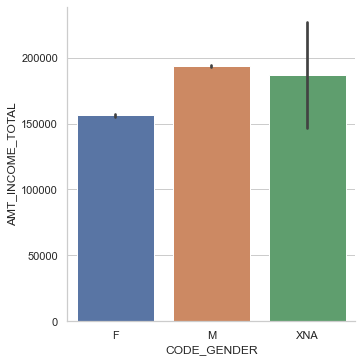

In [15]:
sns.catplot(x="CODE_GENDER", y="AMT_INCOME_TOTAL",kind="bar", data=appTrain)

Les personnes de sex masculin gagnent plus que les autres

KeyboardInterrupt: 

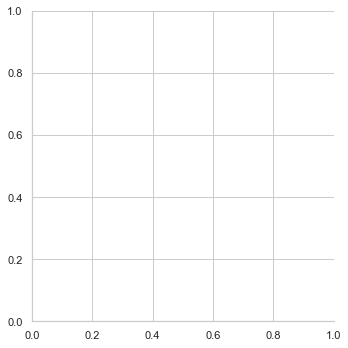

In [16]:
sns.catplot(x="TARGET", y="AMT_INCOME_TOTAL",kind="bar", hue="CODE_GENDER" ,data=appTrain)

Le salaire ne semble pas être un facteur important de défaut de paiement. Nous voyons que les femmes en défaut de paiement gagnent en moyenne plus que les femmes en non défaut de paiement. En revanche les hommes en défaut de paiement gagnent moins, un peu moins

In [ ]:
appTrain["CODE_GENDER"].value_counts(normalize=True)

Les femmes constituent 66% du dataset

In [ ]:
appTrain["CODE_GENDER"].value_counts()

In [ ]:
appTrain[appTrain["TARGET"]==1]["CODE_GENDER"].value_counts()

In [ ]:
appTrain["TARGET"].value_counts()

In [ ]:
appTrain[appTrain["TARGET"]==1]["CODE_GENDER"].value_counts()/appTrain["CODE_GENDER"].value_counts()

Ramener à la proportion du genre, 10% des hommes sont en défaut de paiement et 6% des femmes.

In [ ]:
sns.catplot(x="CODE_GENDER", y="AMT_INCOME_TOTAL",kind="bar", data=appTrain)

In [ ]:
# homeCredit["Description"].str.contains('id', flags=re.IGNORECASE, regex=True).sum()

In [ ]:
# aa = Description("CODE_GENDER")

In [ ]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrain, x="AMT_CREDIT")
plt.show()

In [ ]:
appTrain

In [ ]:
Description("NAME_CONTRACT_TYPE")

In [ ]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrain, x="AMT_CREDIT", hue='CODE_GENDER')
plt.show()

In [ ]:
print(pd.crosstab(appTrain['NAME_CONTRACT_TYPE'], appTrain['TARGET'], margins = True))

In [ ]:
ax = sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=appTrain)

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=appTrain)

In [ ]:
appTrain["credSURrevenu"] = appTrain["AMT_CREDIT"]/appTrain["AMT_INCOME_TOTAL"]

In [ ]:
appTrain["annuitySURrevenu"] = appTrain["AMT_ANNUITY"]/appTrain["AMT_INCOME_TOTAL"]

In [ ]:
appTrain

In [ ]:
Description("OCCUPATION_TYPE")

In [ ]:
print(pd.crosstab(appTrain['NAME_FAMILY_STATUS'], appTrain['TARGET'],
              values=appTrain['credSURrevenu'], aggfunc='mean'))

In [ ]:
print(pd.crosstab(appTrain['NAME_INCOME_TYPE'], appTrain['TARGET'],
              values=appTrain['credSURrevenu'], aggfunc='mean'))

In [ ]:
sns.catplot(x="TARGET", y="annuitySURrevenu",kind="bar", data=appTrain)

In [ ]:
sns.catplot(x="TARGET", y="credSURrevenu",kind="bar", data=appTrain)

In [ ]:
appTrain.boxplot(column = ['annuitySURrevenu'], by = 'TARGET', figsize=(20,15))
plt.title('moyenne du pourcentage des versements sur les révenus')
plt.suptitle('')
plt.show()

In [ ]:

sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=appTrain)

In [ ]:
appTrain.groupby(by="TARGET")["DAYS_EMPLOYED"].mean()

In [ ]:
appTrain[appTrain["DAYS_EMPLOYED"]>50000]

In [ ]:
dire = Description("DAYS_EMPLOYED")

In [ ]:
dire

In [ ]:
appTrain[appTrain["DAYS_EMPLOYED"]!=365243]

In [ ]:
sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=appTrain[appTrain["DAYS_EMPLOYED"]!=365243])

365243 = XNA = NAN
Aussi de manière significatif, nous pouvons constater que le nombre de jour de salariat est en corrélation avec le défaut statut.

In [ ]:
appTrain[appTrain["DAYS_EMPLOYED"]!=365243]

In [ ]:
moYappTrain = appTrain.copy()

In [ ]:
moYappTrain.loc[moYappTrain["DAYS_EMPLOYED"]==365243, "DAYS_EMPLOYED"] = moYappTrain.loc[moYappTrain["DAYS_EMPLOYED"]!=365243, "DAYS_EMPLOYED"].mean()

In [ ]:
moYappTrain.shape

In [ ]:
moYappTrain.loc[moYappTrain["DAYS_EMPLOYED"]!=365243, "DAYS_EMPLOYED"].mean()

On remplace les 365243, par la moyenne.

In [ ]:
sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=moYappTrain)

# une première modélisation rapide

In [ ]:
moYappTrain = moYappTrain[moYappTrain["AMT_ANNUITY"].notna()]

In [ ]:
col = colNul(moYappTrain, 0)

In [ ]:
col

In [ ]:
Description('ORGANIZATION_TYPE')

In [ ]:
moYappTrain_0 = moYappTrain[col].copy()

In [ ]:
moYappTrain_0.shape

# Logistic regression

In [ ]:
X = moYappTrain_0[['annuitySURrevenu','DAYS_EMPLOYED','AMT_INCOME_TOTAL', 'AMT_CREDIT']]
y = moYappTrain_0[['TARGET']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

In [ ]:
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

In [ ]:
print(clf_logistic.coef_)

In [ ]:
clf_logistic.predict_proba(X_test)

In [ ]:
prob_default = pd.DataFrame(clf_logistic.predict_proba(X_test))[1][:]

In [ ]:
clf_logistic.score(X_test, y_test)

In [ ]:
prob_default

# ROC

In [ ]:
# fallout, sensitivity, thresholds = metrics.roc_curve(y_test, prob_default)
# plt.plot(fallout, sensitivity, color = 'darkorange')

In [ ]:
preds_df = pd.DataFrame(np.array(prob_default), columns = ['prob_default'])

In [ ]:
prob_default

In [ ]:
preds_df

In [ ]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

In [ ]:
print(preds_df['loan_status'].value_counts())

In [ ]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

In [ ]:
print(precision_recall_fscore_support(y_test,preds_df['loan_status']))

In [ ]:
print(precision_recall_fscore_support(y_test,preds_df['loan_status'])[:2])

In [ ]:

preds = clf_logistic.predict_proba(X_test)

print(clf_logistic.score(X_test, y_test))


prob_default = preds[:, 1]
fallout, sensitivity, thresholds = metrics.roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()


auc = metrics.roc_auc_score(y_test, prob_default)

# Matrice de confusion

# seuil 0.5

In [ ]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
print(metrics.confusion_matrix(y_test,preds_df['loan_status']))

# seuil 0.4

In [ ]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
print(metrics.confusion_matrix(y_test,preds_df['loan_status']))

# coût

In [ ]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

In [ ]:
num_defaults = preds_df['loan_status'].value_counts()[1]

In [ ]:
num_defaults

In [ ]:
default_recall = metrics.precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

In [ ]:
print(moYappTrain_0["AMT_CREDIT"].mean()* num_defaults * (1 - default_recall))

# idéal

In [ ]:
thresh = [0.2, 0.225,0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]

In [ ]:
def_recalls = []
nondef_recalls = []
acc = []

In [ ]:
for i in thresh:
    preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > i else 0)
    acc.append(metrics.accuracy_score(y_test, preds_df['loan_status']))
    def_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1])
    nondef_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][0])

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(thresh, def_recalls)
plt.plot(thresh, nondef_recalls)
plt.plot(thresh, acc)
plt.xlabel("seul")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

# XGBoost

In [ ]:
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

In [ ]:
gbt_preds = clf_gbt.predict_proba(X_test)

In [ ]:
gbt_PD = pd.DataFrame(gbt_preds)[1][:]

In [ ]:
gbt_PD

In [ ]:
prob_default

In [ ]:
portfolio = pd.concat([preds_df["prob_default"].reset_index(),gbt_PD.reset_index(),
                       X_test["AMT_CREDIT"].reset_index()], axis=1)

In [ ]:
portfolio

In [ ]:
portfolio.drop('index', axis=1, inplace=True)

In [ ]:
portfolio

In [ ]:
portfolio['gbt_expected_loss'] = portfolio[1] *  portfolio['AMT_CREDIT']
portfolio['lr_expected_loss'] = portfolio['prob_default'] * portfolio['AMT_CREDIT']

In [ ]:
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss'] ))
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

# Report

In [ ]:
gbt_preds = clf_gbt.predict(X_test)

In [ ]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

# Quelle colonne est importante

In [ ]:
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

In [ ]:
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

# Resampling

In [ ]:
X_train

In [ ]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)

In [ ]:
count_nondefault, count_default = X_y_train['TARGET'].value_counts()

In [ ]:
nondefaults = X_y_train[X_y_train['TARGET'] == 0]
defaults = X_y_train[X_y_train['TARGET'] == 1]

In [ ]:
nondefaults_under = nondefaults.sample(count_default)

In [ ]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [ ]:
print(X_y_train_under['TARGET'].value_counts())

In [ ]:
X = X_y_train_under.drop('TARGET', axis=1)

In [ ]:
X

In [ ]:
y = X_y_train_under['TARGET']

In [ ]:
clfR_gbt = xgb.XGBClassifier().fit(X, np.ravel(y))

In [ ]:
gbt2_preds = clfR_gbt.predict(X_test)

In [ ]:
print(classification_report(y_test, gbt2_preds, target_names=target_names))

In [ ]:
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt2_preds, target_names=target_names))

Le second modèle est plus performant si on mesure les pertes vue qu'il trouve plus "defaut"

# Matrice confusion

In [ ]:
print(metrics.confusion_matrix(y_test,gbt_preds))
print(metrics.confusion_matrix(y_test,gbt2_preds))

In [ ]:
print(metrics.roc_auc_score(y_test, gbt_preds))
print(metrics.roc_auc_score(y_test, gbt2_preds))

# Logistique

In [ ]:
clfR_logistic = LogisticRegression(solver='lbfgs').fit(X, np.ravel(y))

In [ ]:
log2_preds = clfR_logistic.predict(X_test)

In [ ]:
print(classification_report(y_test, log2_preds, target_names=target_names))

Evaluation des deux modèles

In [ ]:
pd.DataFrame(clfR_logistic.predict_proba(X_test))[1]

In [ ]:
pd.DataFrame(clfR_logistic.predict_proba(X_test))[1].values

In [ ]:
preds_df_lr = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfR_logistic.predict_proba(X_test))[1], pd.Series(clfR_logistic.predict(X_test))], axis=1)), columns=["prob_defaut", "TARGET"])

In [ ]:
preds_df_lr

In [ ]:
X_test

In [ ]:
preds_df_gbt = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfR_gbt.predict_proba(X_test))[1], pd.Series(clfR_gbt.predict(X_test)), X_test['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "TARGET", "AMT_CREDIT"])

In [ ]:
preds_df_gbt

In [ ]:
print(classification_report(y_test, preds_df_lr['TARGET'], target_names=target_names))


print(classification_report(y_test, preds_df_gbt['TARGET'], target_names=target_names))

In [ ]:

fallout_lr, sensitivity_lr, thresholds_lr = metrics.roc_curve(y_test, preds_df_lr["prob_defaut"])
fallout_gbt, sensitivity_gbt, thresholds_gbt = metrics.roc_curve(y_test, preds_df_gbt["prob_defaut"])

plt.figure(figsize=(15,10))
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC comparauson logistic et GBT")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

Taux d'acceptiation

In [ ]:
# Check the statistics of the probabilities of default
print(preds_df_gbt["prob_defaut"].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(preds_df_gbt["prob_defaut"], 0.85)

# Apply acceptance rate threshold
preds_df_gbt['pred_TARGET'] = preds_df_gbt["prob_defaut"].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds_df_gbt['pred_TARGET'].value_counts())

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(preds_df_gbt["prob_defaut"], color = 'blue', bins = 40)

threshold = np.quantile(preds_df_gbt["prob_defaut"], 0.85)

plt.axvline(x = threshold, color = 'red')
plt.show()

In [ ]:
preds_df_gbt['pred_loan_status'] = preds_df_gbt["prob_defaut"].apply(lambda x: 1 if x > threshold else 0)

In [ ]:
np.sum(preds_df_gbt['TARGET'])

In [ ]:
#preds_df_gbt['pred_loan_status'] = preds_df_gbt["prob_defaut"].apply(lambda x: 1 if x > 0.5 else 0)

In [ ]:
accepted_loans = preds_df_gbt[preds_df_gbt['pred_loan_status'] == 0]

In [ ]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

In [ ]:
accepted_loans

# Impact du mauvais taux

In [ ]:
print(preds_df_gbt['AMT_CREDIT'].describe())

# Store the average loan amount
avg_loan = np.mean(preds_df_gbt['AMT_CREDIT'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df_gbt['TARGET'],
                 preds_df_gbt['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

exemple 85%

In [ ]:
pd.reset_option('^display.', silent=True)

In [ ]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [ ]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df_gbt['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df_gbt['prob_defaut'], rate).round(3))
    
    preds_df_gbt['pred_loan_status'] = preds_df_gbt['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df_gbt[preds_df_gbt['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [ ]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

In [ ]:
strat_df

In [ ]:
strat_df.boxplot()
plt.show()

In [ ]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [ ]:
np.sum(preds_df_gbt["prob_defaut"] < np.quantile(preds_df_gbt["prob_defaut"], 1))

In [ ]:
strat_df['Avg'] = avg_loan

In [ ]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df_gbt['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df_gbt["prob_defaut"] < thresh))
    
    

In [ ]:
strat_df['nb_accept'] = nb_accept

In [ ]:
strat_df

In [ ]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

In [ ]:
strat_df

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'],strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

In [ ]:
# moYappTrain_0['AMT_CREDIT'].describe()

In [ ]:
print(strat_df.loc[strat_df['estimation'] == np.max(strat_df['estimation'])])

# Perte total

In [ ]:
preds_df_gbt['perte'] = preds_df_gbt['prob_defaut'] * preds_df_gbt['AMT_CREDIT']

In [ ]:
tot_perte = round(np.sum(preds_df_gbt['perte']),2)

In [ ]:
tot_perte

In [ ]:
dire[18]

In [ ]:
bureauBal

In [ ]:
bureauBal["MONTHS_BALANCE"].describe()

In [ ]:
creditCardBal

In [ ]:
homeCredit

In [ ]:
homeCredit.loc[homeCredit["Row"]=="STATUS",]["Description"].values

In [ ]:
installmentsP

In [ ]:
Description("NUM_INSTALMENT_NUMBER")

In [ ]:
POS_CASH_B

In [ ]:
previous_Apps

In [ ]:
sample_sub

In [ ]:
appTrain

In [ ]:
Description("TARGET")

In [ ]:
appTrain.info()

In [ ]:
appTrain.isna().sum().sort_values()

In [ ]:
appTrain.isna().sum().value_counts()

In [ ]:
Description("AMT_REQ_CREDIT_BUREAU_WEEK")

In [ ]:
appTrain.loc[:,(appTrain.isna().sum() == 12).values]

In [ ]:
Description("AMT_ANNUITY")

In [ ]:
appTrain["AMT_ANNUITY"].describe()

In [ ]:
appTrain.loc[appTrain["AMT_ANNUITY"]==258025.5,]

In [ ]:
Description("AMT_GOODS_PRICE")

In [ ]:
appTrain

In [ ]:
(appTrain["AMT_CREDIT"]-appTrain["AMT_GOODS_PRICE"]).describecribe()

In [ ]:
appTrain.loc[(appTrain["AMT_CREDIT"]-appTrain["AMT_GOODS_PRICE"]) == -765000,]

In [ ]:
bureau

In [ ]:
Description("AMT_CREDIT_SUM_OVERDUE")

In [ ]:
POS_CASH_B

In [ ]:
Description("CREDIT_ACTIVE")

In [ ]:
POS_CASH_B["CNT_INSTALMENT"].describe()

In [ ]:
bureauBal

In [ ]:
bureauBal["MONTHS_BALANCE"].describe()